### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import numpy as np
import pandas as pd
import gc
from tqdm import *
import os
import copy
import sys
from collections import Counter, deque

import transforms3d

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import ipyvolume as ipv
import open3d as o3d

import warnings
warnings.filterwarnings("ignore")


### Set constants and file paths

In [3]:
X_GRID = np.arange(-0.2, 0.225, 0.025)
Y_GRID = np.arange(-0.2, 0.225, 0.025)
THETA_GRID = np.arange(-2, 2.25, 0.25)
# plt.rcParams['figure.figsize'] = [20, 10]

VOXEL_SZ = 0.2

In [4]:
## data: ref_run_ccw_l | experiment: proximal-pose
MAP_FILE = 'map_5loops.pcd'
POSE_FILE = 'pose_5loops.json'

### Helper functions for pcd io

In [5]:
def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,0]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = True,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd

    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def read_pcd(pcd_id):
    pcd_file = str(pcd_id) + ".pcd"
    pcd = o3d.io.read_point_cloud(os.path.join(LIDAR_PCD_PATH, pcd_file))
    return pcd

def draw_pcd(pcd, where='mat_3d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.grid()
        plt.show()
    elif where is 'mat_2d':
        plt.figure()
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.grid()
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()

### Plot map

In [6]:
map_pcd = o3d.io.read_point_cloud(MAP_FILE)

In [7]:
map_pcd

geometry::PointCloud with 43934 points.

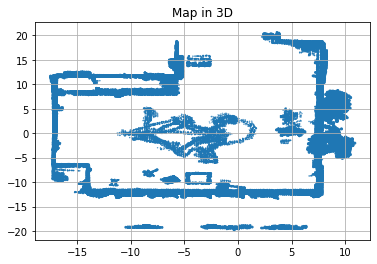

In [8]:
plot_map_pts = np.asarray(map_pcd.points)
plt.figure()
plt.title('Map in 3D',fontsize=12)
plt.grid()
plt.scatter(plot_map_pts[:,0], plot_map_pts[:,1], plot_map_pts[:,2])

In [9]:
draw_pcd(map_pcd, where='opn_nb')

JVisualizer with 1 geometries

### Plot pose

In [18]:
df_pose = pd.read_json(POSE_FILE, lines=True)
df_pose = df_pose[:3000]
df_pose.shape

(3000, 9)

<IPython.core.display.Javascript object>


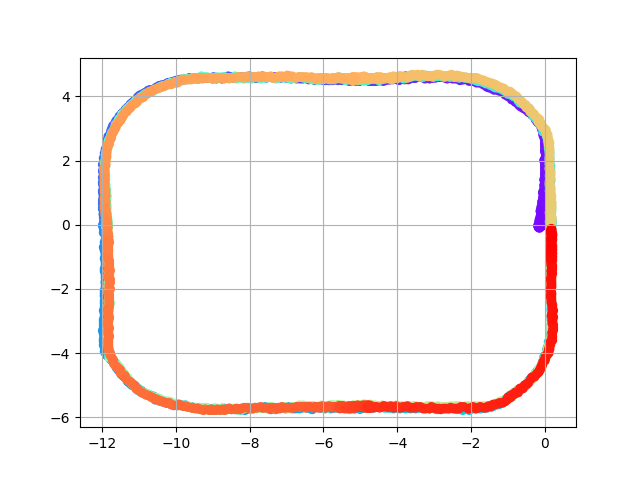

In [19]:
plt.figure()
plt.grid()
plt.scatter(df_pose['x'], df_pose['y'], c=cm.rainbow(np.array(range(df_pose.shape[0]))/df_pose.shape[0]))

### Quick analysis of Pose

In [12]:
df_pose['x_abs'] = [0] + [df_pose.iloc[idx]['x_vel']- df_pose.iloc[idx-1]['x_vel'] for idx in range(df_pose.shape[0]) if idx != 0]
df_pose['y_abs'] = [0] + [df_pose.iloc[idx]['y_vel']- df_pose.iloc[idx-1]['y_vel'] for idx in range(df_pose.shape[0]) if idx != 0]
df_pose['theta_abs'] = [0] + [df_pose.iloc[idx]['theta_vel']- df_pose.iloc[idx-1]['theta_vel'] for idx in range(df_pose.shape[0]) if idx != 0]

In [13]:
print(X_GRID[0], X_GRID[-1])
print(df_pose['x_abs'].min(), df_pose['x_abs'].max())
print("")
print(Y_GRID[0], Y_GRID[-1])
print(df_pose['y_abs'].min(), df_pose['y_abs'].max())
print("")
print(THETA_GRID[0], THETA_GRID[-1])
print(df_pose['theta_abs'].min(), df_pose['theta_abs'].max())

-0.2 0.1999999999999999
-0.125 0.125

-0.2 0.1999999999999999
-0.175 0.175

-2.0 2.0
-1.0 1.25


In [14]:
if df_pose['x_abs'].min() <= X_GRID[0]:
    print("Velocity boundary hit in -X direction")
    print("Expected: {} | Real : {}".format(X_GRID[0], df_pose['x_abs'].min()))

if df_pose['y_abs'].min() <= Y_GRID[0]:
    print("Velocity boundary hit in -Y direction")
    print("Expected: {} | Real : {}".format(Y_GRID[0], df_pose['y_abs'].min()))
    
if df_pose['theta_abs'].min() <= THETA_GRID[0]:
    print("Velocity boundary hit in -THETA direction")
    print("Expected: {} | Real : {}".format(THETA_GRID[0], df_pose['theta_abs'].min()))
    
if df_pose['x_abs'].max() >= X_GRID[-1]:
    print("Velocity boundary hit in +X direction")
    print("Expected: {} | Real : {}".format(X_GRID[-1], df_pose['x_abs'].max()))
    
if df_pose['y_abs'].max() >= Y_GRID[-1]:
    print("Velocity boundary hit in +Y direction")
    print("Expected: {} | Real : {}".format(Y_GRID[-1], df_pose['y_abs'].max()))

if df_pose['theta_abs'].max() >= THETA_GRID[-1]:
    print("Velocity boundary hit in +THETA direction")
    print("Expected: {} | Real : {}".format(THETA_GRID[-1], df_pose['theta_abs'].max()))
    
print("All clear?")

All clear?


### Run animation

In [15]:
grid_folder = MAP_FILE[:-4]

### Experimental

Check if no of points considered for best score is fairly constant or gradually increasing

Check if score variation over all grid points is fairly constant

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


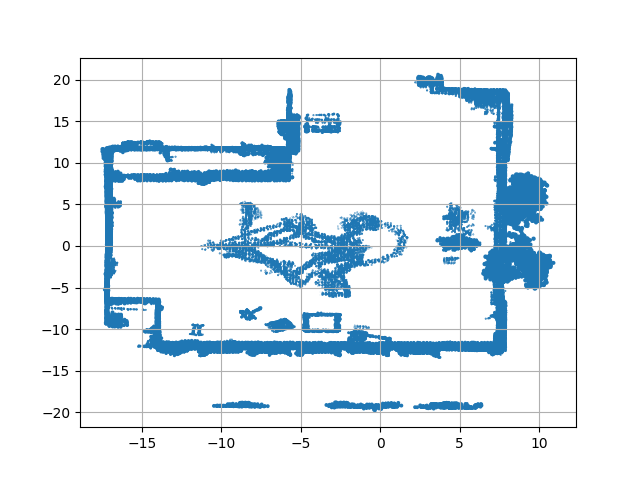

In [20]:
sample_map_pcd = o3d.io.read_point_cloud("map_5loops3000.pcd")
draw_pcd(map_pcd, where='mat_3d')